In [1]:
import ctypes
from ctypes import byref
clib = ctypes.CDLL("../fortran/wrapper.so")
clib.kepler_solve.restype = None
clib.kepler_solve_RPP.restype = None

In [2]:
n = 100
np.random.seed(42)
M = np.random.rand(n) * np.pi * 2
ecc = np.random.rand(n)
ecc[-1] = 0.999999999
ecc[-2] = 0.000000001

In [3]:
def test_RPP_vs_newton(M, ecc):
    
    j = len(M)
    M = byref((ctypes.c_double * j).from_buffer(M))
    
    for e in ecc:
        e = byref(ctypes.c_double(e))
        cosf_newton = (ctypes.c_double * j).from_buffer(np.zeros(j))
        sinf_newton = (ctypes.c_double * j).from_buffer(np.zeros(j))
        cosf_RPP = (ctypes.c_double * j).from_buffer(np.zeros(j))
        sinf_RPP = (ctypes.c_double * j).from_buffer(np.zeros(j))
        newton = clib.kepler_solve(M, e, cosf_newton, sinf_newton, byref(ctypes.c_int(j)))
        RPP = clib.kepler_solve_RPP(M, e, cosf_RPP, sinf_RPP, byref(ctypes.c_int(j)))
        assert np.all(np.isclose(np.array(sinf_RPP), np.array(sinf_newton), atol=1e-12))
        assert np.all(np.isclose(np.array(cosf_RPP), np.array(cosf_newton), atol=1e-12))

In [4]:
test_RPP_vs_newton(M, ecc)

In [5]:
j = len(M)
M = byref((ctypes.c_double * j).from_buffer(M))
e = byref(ctypes.c_double(ecc[0]))
cosf = (ctypes.c_double * j).from_buffer(np.zeros(j))
sinf = (ctypes.c_double * j).from_buffer(np.zeros(j))
clib.kepler_solve_RPP(M, e, cosf, sinf, byref(ctypes.c_int(j)))

In [6]:
import sys
sys.path.append('../gefera')
from kep import impacts, grad_impacts
import matplotlib.pyplot as plt

t = np.linspace(0, 100, 1000)

In [47]:
uniform_draw = lambda l, h: np.random.rand() * (h - l) + l

def random_args():
    
    keys = [
        'ab', 
        'tb', 
        'eb', 
        'pb', 
        'wb', 
        'ib',      
        'am', 
        'tm', 
        'em', 
        'pm', 
        'om', 
        'wm', 
        'im', 
        'mm'
    ]
    
    ab = uniform_draw(1, 10)
    tb = uniform_draw(-10, 10)
    eb = uniform_draw(0, 0.999)
    pb = uniform_draw(10, 100)
    wb = uniform_draw(0, np.pi*2)
    ib = uniform_draw(0, np.pi/2)
    
    am = uniform_draw(0.01, 1)
    tm = uniform_draw(-10, 10)
    em = uniform_draw(0, 0.999)
    pm = uniform_draw(1, 10)
    om = uniform_draw(0, np.pi*2)
    wm = uniform_draw(0, np.pi*2)
    im = uniform_draw(0, np.pi/2)
    mm = uniform_draw(0, 1)
    
    argdict = {
        k: v for k, v in zip(
            keys, 
            (ab, tb, eb, pb, wb, ib, am, tm, em, pm, om, wm, im, mm)
        )
    }
    
    return argdict

In [48]:
from copy import copy
def test_gradient(p):
    d = 0.000001
    t = np.linspace(0, 100, 100)
    argdict = random_args()
    ind = np.where(np.array(list(argdict.keys())) == p)[0][0]
    pargdict = copy(argdict)
    margdict = copy(argdict)
    pargdict[p] = argdict[p] + d
    margdict[p] = argdict[p] - d
    pbp, pbpm, ptheta = impacts(t, pargdict)
    mbp, mbpm, mtheta = impacts(t, margdict)
    _, _, _, dbp, dbpm, dtheta = grad_impacts(t, argdict)
    fdiff_bp = (pbp - mbp) / (2 * d)
    fdiff_bpm = (pbpm - mbpm) / (2 * d)
    fdiff_theta = (ptheta - mtheta) / (2 * d)
    
    tol = 1e-3
    
    if p == 'pb':
        tol = 0.1
    if p == 'pm':
        tol = 0.5
    
    try:
        assert np.all(np.isclose(fdiff_bp, dbp[ind], atol=tol))
    except:
        fig, axs = plt.subplots(1, 2)
        print("eb = ", argdict['eb'])
        print("em = ", argdict['em'])
        print(np.max(np.abs(fdiff_bp - dbp[ind])))
        print(p, argdict[p])
        axs[0].plot(t, fdiff_bp)
        axs[0].plot(t, dbp[ind])
        axs[1].plot(t, fdiff_bp - dbp[ind], '.')
    try:
        assert np.all(np.isclose(fdiff_bpm, dbpm[ind], atol=tol))
    except:
        fig, axs = plt.subplots(1, 2)
        print("eb = ", argdict['eb'])
        print("em = ", argdict['em'])
        print(np.max(np.abs(fdiff_bpm - dbpm[ind])))
        print(p, argdict[p])
        axs[0].plot(t, fdiff_bpm)
        axs[0].plot(t, dbpm[ind])
        axs[1].plot(t, fdiff_bpm - dbpm[ind], '.')
    try:
        assert np.all(np.isclose(fdiff_theta, dtheta[ind], atol=tol))
    except:
        fig, axs = plt.subplots(1, 2)
        print("eb = ", argdict['eb'])
        print("em = ", argdict['em'])
        print(np.max(np.abs(fdiff_theta - dtheta[ind])))
        print(p, argdict[p])
        axs[0].plot(t, fdiff_theta)
        axs[0].plot(t, dtheta[ind])
        axs[1].plot(t, fdiff_theta - dtheta[ind], '.')

In [49]:
#diff, fdiff = test_gradient('mm')
#plt.plot(t, fdiff - diff)
#plt.plot(t, diff)

eb =  0.6933027992491114
em =  0.9468188466460734
1.3213355655316263
pm 1.3739533177311556


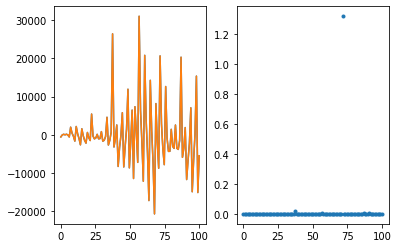

In [75]:
[test_gradient('ab') for _ in range(10)];
[test_gradient('tb') for _ in range(10)];
[test_gradient('eb') for _ in range(10)];
[test_gradient('pb') for _ in range(10)];
[test_gradient('wb') for _ in range(10)];
[test_gradient('ib') for _ in range(10)];
[test_gradient('am') for _ in range(10)];
[test_gradient('tm') for _ in range(10)];
[test_gradient('em') for _ in range(10)];
[test_gradient('pm') for _ in range(10)];
[test_gradient('om') for _ in range(10)];
[test_gradient('wm') for _ in range(10)];
[test_gradient('im') for _ in range(10)];
[test_gradient('mm') for _ in range(10)];

In [ ]:
import matplotlib.pyplot as plt
t = np.linspace(0, 100, 1000)
argdict = random_args()
bp, bpm, theta = impacts(t, argdict)
_, _, _, dbp, dbpm, dtheta = grad_impacts(t, argdict)
plt.plot(t, bp)

In [ ]:
np.where(list(argdict.keys()) == 'am')

In [ ]:
np.where(np.array(list(argdict.keys())) == 'pb')[0][0]

In [157]:
argdict = random_args()
argdict['am'] = 0.0
am = argdict['ab']
argdict['eb'] = 0.0
argdict['em'] = 0.0

In [158]:
from kep import coords
t = np.linspace(0, 100, 10)
xp, yp, zp, xm, ym, zm = coords(t, argdict)

In [159]:
np.all(np.isclose((xm - xp)**2 + (ym - yp)**2 + (zm - zp)**2, am ** 2, atol=1e-10))

False

In [160]:
am**2

1.37306653066042

In [162]:
(xm)**2 + (ym)**2 + (zm)**2

array([1.37306653, 1.37306653, 1.37306653, 1.37306653, 1.37306653,
       1.37306653, 1.37306653, 1.37306653, 1.37306653, 1.37306653])

In [163]:
(xp)**2 + (yp)**2 + (zp)**2

array([1.37306653, 1.37306653, 1.37306653, 1.37306653, 1.37306653,
       1.37306653, 1.37306653, 1.37306653, 1.37306653, 1.37306653])